In [1]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import savgol_filter, find_peaks
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
def gompertz(t, A, mu, l):
    log_B = A * np.exp(-np.exp(mu * np.exp(1) / A * (l - t) + 1))
    return log_B

In [3]:
def gompertz_growth_rate(t, A, mu, l):
    gr = mu * np.exp(np.exp(1) * mu * (l - t) / A - np.exp(np.exp(1) * mu * (l - t) / A + 1) + 2)
    return gr

In [4]:
def tm_gomp(A, mu, l):
    return A / (mu * np.e) + l

In [5]:
exp_sum = pd.read_excel('../Exps_summary.xlsx')
positions = pd.read_excel('../Positions.xlsx')

df = pd.read_excel('../data_processed.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')

pos_grouped = positions.groupby(['Date', 'Machine', 'Pad'])['colonies'].sum().reset_index()
pos_grouped.rename(columns={'colonies': 'total_colonies'}, inplace=True)

# Group by 'Date', 'Machine', and 'Pad' and calculate mean, std, and count of 'area_max_um'
agg_colony_area_df = df.groupby(['Date', 'Machine', 'Pad'])['area_max_um'].agg(['mean', 'std', 'count']).reset_index()

# Rename the columns for clarity
agg_colony_area_df.rename(columns={'mean': 'mean_colony_area', 'std': 'std_colony_area', 'count': 'num_colonies'}, inplace=True)

# Merge the grouped data from 'positions' and the aggregated colony area data from 'df'
df_N_A = pd.merge(pos_grouped, agg_colony_area_df, on=['Date', 'Machine', 'Pad'], how='inner')

# Display the merged dataframe
df_N_A

,Date,Machine,Pad,total_colonies,mean_colony_area,std_colony_area,num_colonies
0,2023-11-15,Ti scope,1,19.0,1.274945e+05,21643.298316,7
1,2023-11-15,Ti scope,2,23.0,4.672517e+04,15593.763903,2
2,2023-11-15,Tweez scope,1,3.0,7.684826e+05,99168.204670,2
3,2023-11-15,Tweez scope,2,1.0,4.760315e+05,NaN,1
4,2023-11-17,Ti scope,1,6.0,3.668106e+05,47734.937249,6
5,2023-11-17,Tweez scope,1,3.0,9.387205e+05,NaN,1
6,2023-11-17,Tweez scope,2,1.0,6.881031e+05,NaN,1
7,2023-11-28,Ti scope,1,5.0,7.854782e+05,NaN,1
8,2023-11-28,Ti scope,2,2.0,1.056034e+06,62477.978681,2
9,2023-11-28,Tweez scope,1,14.0,3.800202e+05,139119.174347,11


#### A*N vs N

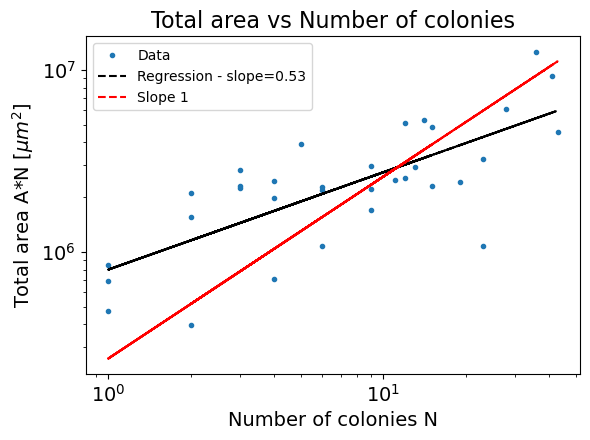

In [44]:
AN = df_N_A['total_colonies'] * df_N_A['mean_colony_area']

# linear regression in log-log space
log_N = np.log10(df_N_A['total_colonies'])
log_AN = np.log10(AN)

# fit the regression model (linear fit in log-log space)
slope, intercept = np.polyfit(log_N, log_AN, 1)
# create the regression line in log-log space
regression_line = 10**(slope * log_N + intercept)

# Calculate the scaling factor to align the slope 1 line with the data
scaling_factor = (df_N_A['total_colonies'] * df_N_A['mean_colony_area']).mean() / df_N_A['total_colonies'].mean()
# Plotting a slope 1 line for reference in log-log space, scaled to match the data
slope_1_line = scaling_factor * df_N_A['total_colonies']  # Slope 1 line

plt.figure(figsize=(6,4.5))
plt.yscale('log')
plt.xscale('log')

plt.plot(df_N_A['total_colonies'], AN, '.', label='Data')
plt.plot(df_N_A['total_colonies'], regression_line, '--', label=f'Regression - slope={slope:.2f}', color='black')
plt.plot(df_N_A['total_colonies'], slope_1_line, '--', label='Slope 1', color='red')

plt.ylabel('Total area A*N [$\mu m^2$]', fontsize=14)
plt.xlabel('Number of colonies N', fontsize=14)
plt.title('Total area vs Number of colonies', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)  # Adjust the tick size here

plt.legend()
plt.tight_layout()
plt.savefig('AN_N.png', dpi=300)
plt.show()

#### Gompertz params vs N

In [45]:
df_gomp = df.groupby(['Date','Machine','Pad'])[['A_gomp_um','mu_gomp_um','l_gomp_um']].agg(['mean','std']).reset_index()
df_gomp.columns = ['_'.join(filter(None, col)).strip('_') for col in df_gomp.columns.values]
df_gomp.head()

,Date,Machine,Pad,A_gomp_um_mean,A_gomp_um_std,mu_gomp_um_mean,mu_gomp_um_std,l_gomp_um_mean,l_gomp_um_std
0,2023-11-15,Ti scope,1,124844.505297,21029.802963,414.191407,76.516590,347.800191,14.380969
1,2023-11-15,Ti scope,2,44951.936568,14489.775612,115.569528,45.912740,390.868408,13.372949
2,2023-11-15,Tweez scope,1,761776.515325,97483.118497,1649.906803,39.333283,438.492732,32.238057
3,2023-11-15,Tweez scope,2,469881.069646,NaN,1050.361432,NaN,423.652960,NaN
4,2023-11-17,Ti scope,1,362891.221616,47016.657638,801.770163,124.341047,373.917657,12.847217


In [46]:
# merge total colonies and average area with gompertz params dataframes
df_N_A_gomp = pd.merge(df_gomp, df_N_A, on=['Date', 'Machine', 'Pad'], how='inner')

# Display the merged dataframe
df_N_A_gomp.head()

,Date,Machine,Pad,A_gomp_um_mean,A_gomp_um_std,mu_gomp_um_mean,mu_gomp_um_std,l_gomp_um_mean,l_gomp_um_std,total_colonies,mean_colony_area,std_colony_area,num_colonies
0,2023-11-15,Ti scope,1,124844.505297,21029.802963,414.191407,76.516590,347.800191,14.380969,19.0,127494.473143,21643.298316,7
1,2023-11-15,Ti scope,2,44951.936568,14489.775612,115.569528,45.912740,390.868408,13.372949,23.0,46725.168600,15593.763903,2
2,2023-11-15,Tweez scope,1,761776.515325,97483.118497,1649.906803,39.333283,438.492732,32.238057,3.0,768482.640000,99168.204670,2
3,2023-11-15,Tweez scope,2,469881.069646,NaN,1050.361432,NaN,423.652960,NaN,1.0,476031.532500,NaN,1
4,2023-11-17,Ti scope,1,362891.221616,47016.657638,801.770163,124.341047,373.917657,12.847217,6.0,366810.583800,47734.937249,6


In [47]:
pos_grouped = positions.groupby(['Date', 'Machine', 'Pad'])['colonies'].sum().reset_index()
pos_grouped.rename(columns={'colonies': 'total_colonies'}, inplace=True)

# Merge the grouped data back into the original DataFrame
df_N_A_gomp_all_pos = df.merge(pos_grouped, on=['Date', 'Machine', 'Pad'], how='left')

# Display the updated DataFrame
df_N_A_gomp_all_pos.head()

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,t_incub,t_im,...,r0_um,A_gomp_um,mu_gomp_um,l_gomp_um,ts_10,tm_um,A_gomp_px,mu_gomp_px,l_gomp_px,total_colonies
0,2023-11-15,Ti scope,0,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,25.726989,103786.407908,343.235436,366.413055,982,477.651236,79860.270682,264.108533,366.413060,19.0
1,2023-11-15,Ti scope,1,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,37.567485,148648.903676,486.687306,354.501107,1015,466.862525,114380.499530,374.490570,354.501291,19.0
2,2023-11-15,Ti scope,3,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,50.002925,138470.390891,463.743309,343.273546,984,453.119680,106548.466672,356.835713,343.273661,19.0
3,2023-11-15,Ti scope,6,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,23.368757,100919.606151,319.217899,320.089585,955,436.393365,77654.359914,245.627809,320.089585,19.0
4,2023-11-15,Ti scope,7,MC4100,pLPT20&pLPT41,-,1,10^(-5),09:25:00,14:41:00,...,35.216651,131433.344500,451.356518,345.419708,968,452.544838,101133.690444,347.304220,345.419723,19.0


#### A vs area_max_um

Text(0, 0.5, 'A Gomp')

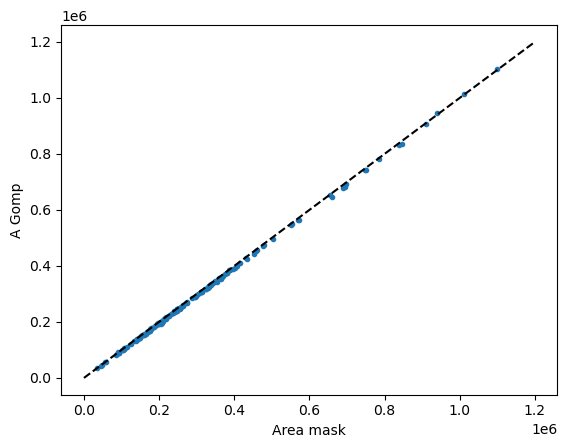

In [48]:
plt.plot(df['area_max_um'],df['A_gomp_um'],'.')
plt.plot(np.arange(0,1.2e6), np.arange(0,1.2e6), 'k--')
plt.xlabel('Area mask')
plt.ylabel('A Gomp')

#### A vs N

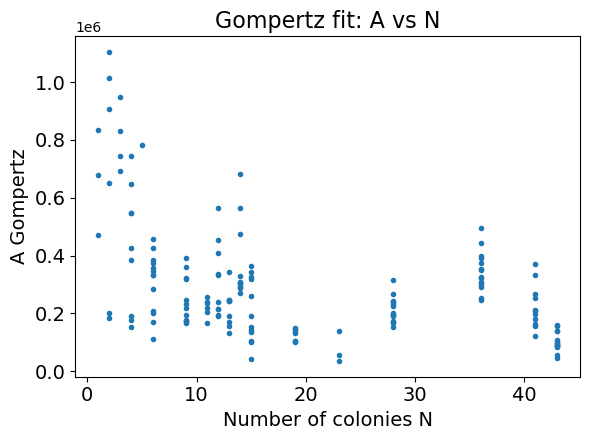

In [49]:
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df_N_A_gomp_all_pos['A_gomp_um'], '.')
plt.ylabel('A Gompertz', fontsize=14)
plt.xlabel('Number of colonies N', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Gompertz fit: A vs N', fontsize=16)
plt.tight_layout()
plt.savefig('AGomp_N.png', dpi=300)
plt.show()


#### $\mu_m$ vs N

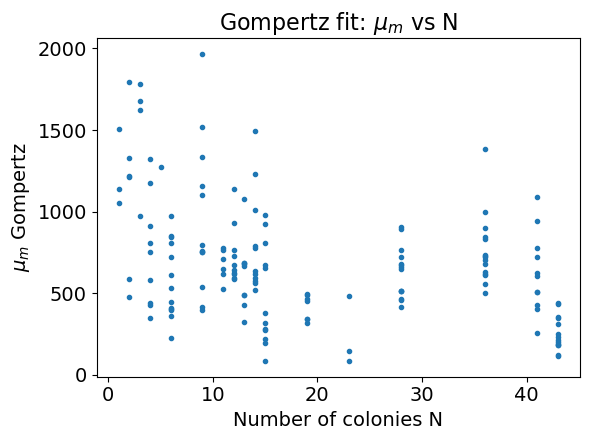

In [50]:
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df_N_A_gomp_all_pos['mu_gomp_um'], '.')
plt.ylabel('$\\mu_m$ Gompertz', fontsize=14)
plt.xlabel('Number of colonies N', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Gompertz fit: $\mu_m$ vs N', fontsize=16)
plt.tight_layout()
plt.savefig('muGomp_N.png', dpi=300)
plt.show()

#### $\lambda$ vs N

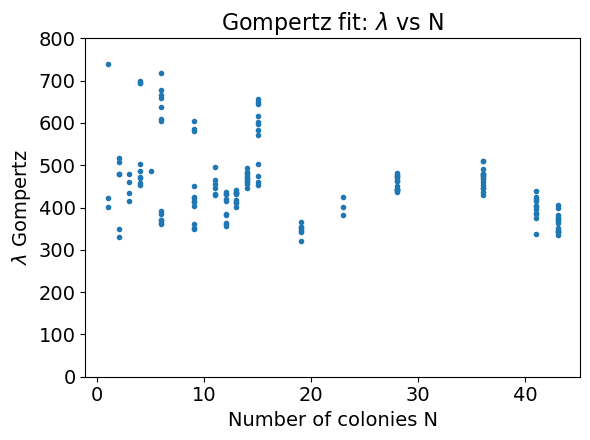

In [51]:
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df_N_A_gomp_all_pos['l_gomp_um'], '.')
plt.ylabel('$\\lambda$ Gompertz', fontsize=14)
plt.ylim([0, 800])
plt.xlabel('Number of colonies N', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Gompertz fit: $\lambda$ vs N', fontsize=16)
plt.tight_layout()
plt.savefig('lGomp_N.png', dpi=300)
plt.show()


#### $r_0$ vs N

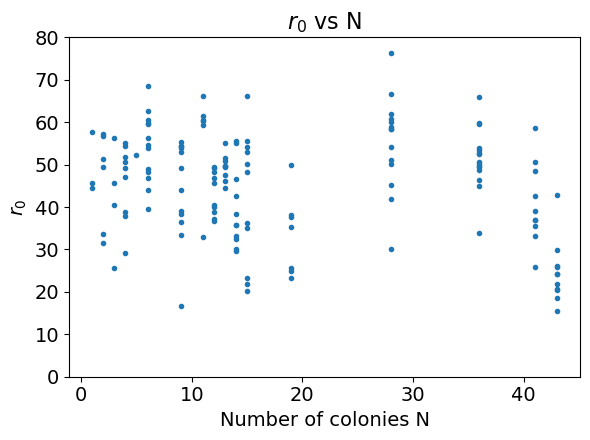

In [52]:
df_N_A_gomp_all_pos_r0 = df_N_A_gomp_all_pos[df_N_A_gomp_all_pos.r0_um > 1]

plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos_r0['total_colonies'], df_N_A_gomp_all_pos_r0['r0_um'], '.')
plt.ylabel('$r_0$', fontsize=14)
plt.ylim([0, 80])
plt.xlabel('Number of colonies N', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('$r_0$ vs N', fontsize=16)
plt.tight_layout()
plt.savefig('r0_N.png', dpi=300)
plt.show()


#### A vs $r_0$

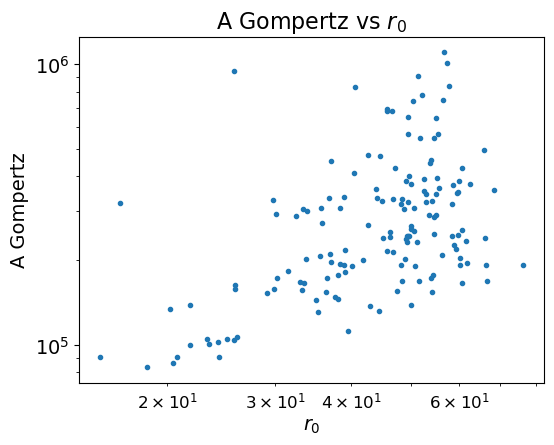

In [23]:
plt.figure(figsize=(6,4.5))

plt.yscale('log')
plt.xscale('log')

plt.plot(df_N_A_gomp_all_pos_r0['r0_um'], df_N_A_gomp_all_pos_r0['A_gomp_um'], '.')
plt.xlabel('$r_0$', fontsize=14)
plt.ylabel('A Gompertz', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.title('A Gompertz vs $r_0$', fontsize=16)
plt.tight_layout()
#plt.savefig('AGomp_r0.png', dpi=300)
plt.show()

In [24]:
#df.to_excel('../data_processed.xlsx', index=False)

In [25]:
df = pd.read_excel('../data_processed.xlsx')

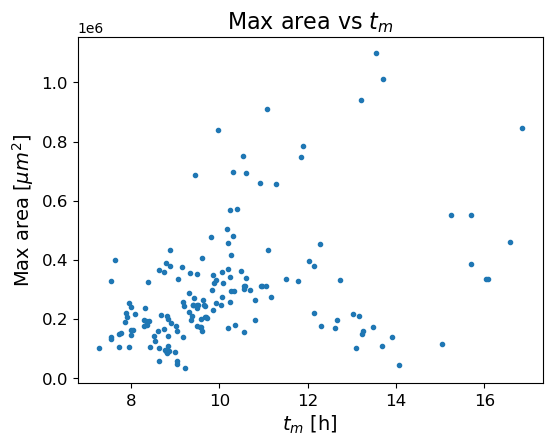

In [26]:
plt.figure(figsize=(6,4.5))

plt.plot(df['tm_um'] / 60, df['area_max_um'], '.')
plt.ylabel('Max area [$\\mu m^2$]', fontsize=14)
# plt.ylim([0,50])
plt.xlabel('$t_m$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title('Max area vs $t_m$', fontsize=16)
plt.tight_layout()
#plt.savefig('MaxA_tm.png', dpi=300)
plt.show()


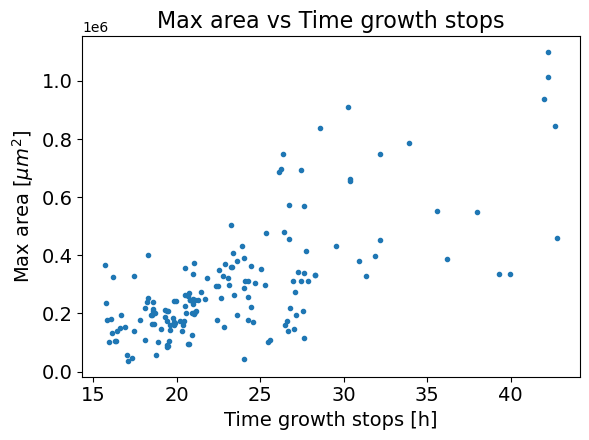

In [53]:
plt.figure(figsize=(6,4.5))

plt.plot(df['ts_10'] / 60, df['area_max_um'], '.')
plt.xlabel('Time growth stops [h]', fontsize=14)
plt.ylabel('Max area [$\\mu m^2$]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Max area vs Time growth stops', fontsize=16)
plt.tight_layout()
plt.savefig('MaxA_tstop.png', dpi=300)
plt.show()

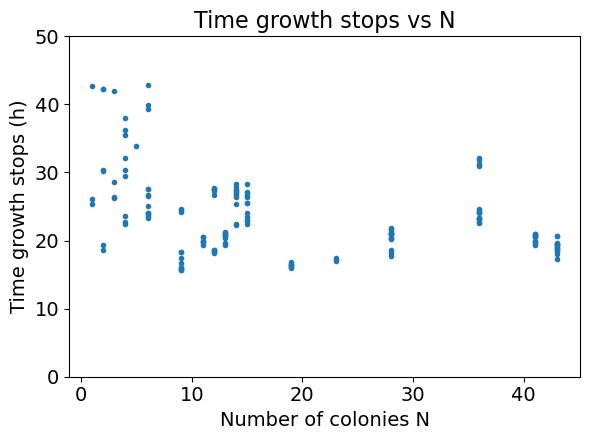

In [54]:
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df['ts_10'] / 60, '.')
plt.ylabel('Time growth stops (h)', fontsize=14)
plt.ylim([0, 50])
plt.xlabel('Number of colonies N', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Time growth stops vs N', fontsize=16)
plt.tight_layout()
plt.savefig('tstop_N.png', dpi=300)
plt.show()

In [22]:
df = pd.read_excel('../data_processed.xlsx')

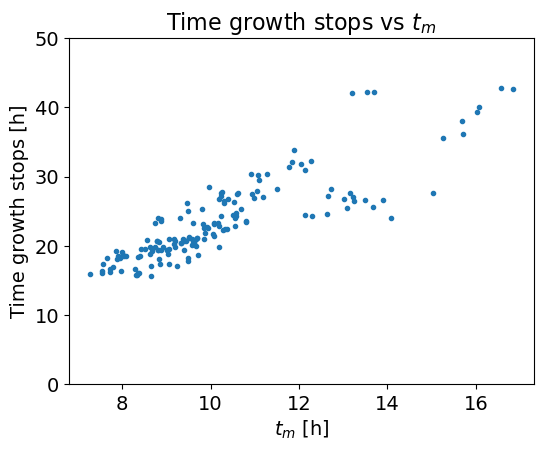

In [30]:
plt.figure(figsize=(6,4.5))

plt.plot(df['tm_um'] / 60, df['ts_10'] / 60, '.')
plt.ylabel('Time growth stops [h]', fontsize=14)
plt.ylim([0, 50])
plt.xlabel('$t_m$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Time growth stops vs $t_m$', fontsize=16)
plt.tight_layout()
#plt.savefig('tstop_tm.png', dpi=300)
plt.show()

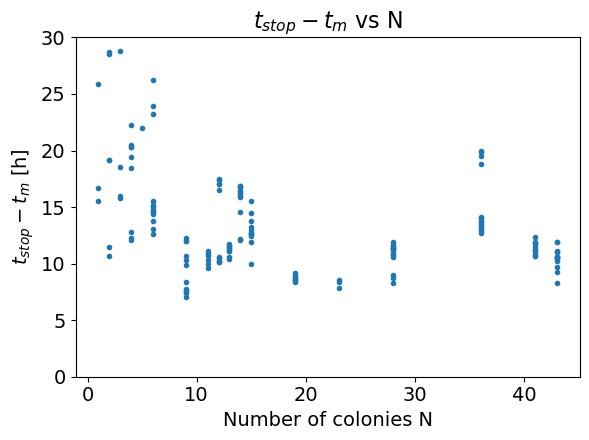

In [55]:
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df['ts_10'] / 60 - df['tm_um'] / 60, '.')
plt.xlabel('Number of colonies N', fontsize=14)
plt.ylabel('$t_{stop} - t_m$ [h]', fontsize=14)
plt.ylim([0, 30])

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('$t_{stop} - t_m$ vs N', fontsize=16)
plt.tight_layout()
plt.savefig('tstop-tm_N.png', dpi=300)
plt.show()


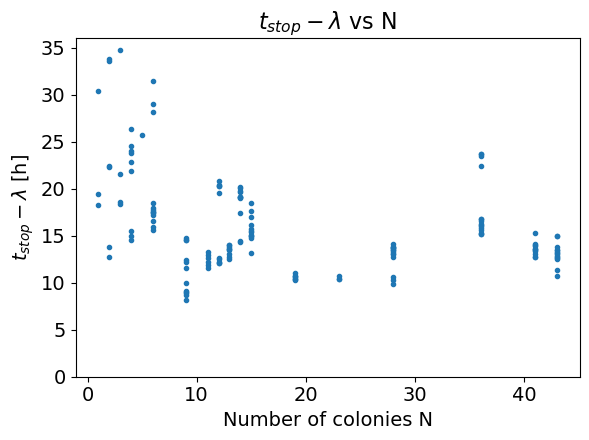

In [56]:
## is there a constant value for tstop - lambda?
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df['ts_10'] / 60 - df['l_gomp_um'] / 60, '.')
plt.xlabel('Number of colonies N', fontsize=14)
plt.ylabel('$t_{stop} - \\lambda$ [h]', fontsize=14)
plt.ylim([0, 36])

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('$t_{stop} - \\lambda$ vs N', fontsize=16)
plt.tight_layout()
plt.savefig('tstop-lambda_N.png', dpi=300)
plt.show()

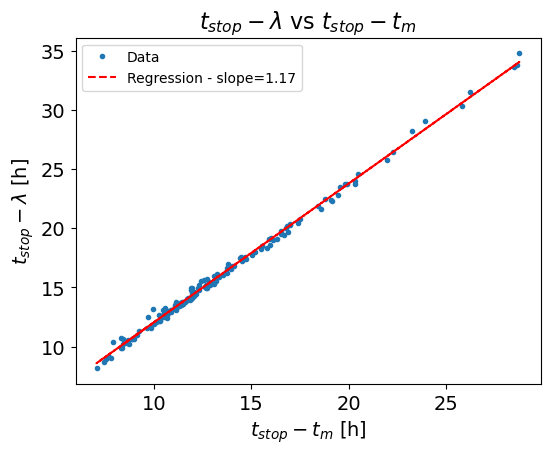

In [34]:
plt.figure(figsize=(6,4.5))

# Data for the plot
x = df['ts_10'] / 60 - df['tm_um'] / 60
y = df['ts_10'] / 60 - df['l_gomp_um'] / 60

# Perform the linear regression
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept  # Calculate the regression line

# Plot the data points
plt.plot(x, y, '.', label='Data')

# Plot the regression line
plt.plot(x, regression_line, '--', color='red', label=f'Regression - slope={slope:.2f}')

# Labels and title
plt.xlabel('$t_{stop} - t_m$ [h]', fontsize=14)
plt.ylabel('$t_{stop} - \\lambda$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

# Title and legend
plt.title('$t_{stop} - \\lambda$ vs $t_{stop} - t_m$', fontsize=16)
plt.legend()
plt.tight_layout()
#plt.savefig('tstop-lambda_tstop-tm.png', dpi=300)
# Show plot
plt.show()


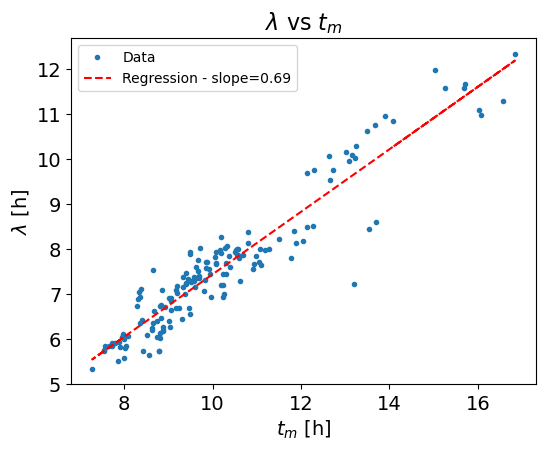

In [35]:
plt.figure(figsize=(6,4.5))

# Scatter plot
plt.plot(df['tm_um'] / 60, df['l_gomp_um'] / 60, '.', label='Data')

# Linear regression (fit a line)
slope, intercept = np.polyfit(df['tm_um'] / 60, df['l_gomp_um'] / 60, 1)
regression_line = slope * (df['tm_um'] / 60) + intercept

# Plot the regression line
plt.plot(df['tm_um'] / 60, regression_line, '--', color='red', label=f'Regression - slope={slope:.2f}')

plt.xlabel('$t_m$ [h]', fontsize=14)
plt.ylabel('$\\lambda$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('$\\lambda$ vs $t_m$', fontsize=16)

# Add a legend for the regression line
plt.legend()
plt.tight_layout()
plt.savefig('lambda_tm.png', dpi=300)
plt.show()


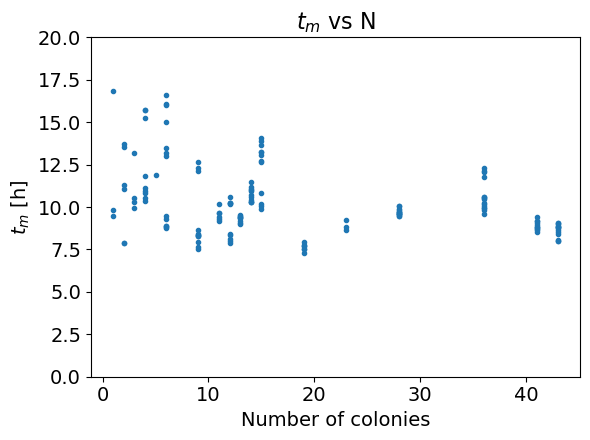

In [57]:
plt.figure(figsize=(6,4.5))

plt.plot(df_N_A_gomp_all_pos['total_colonies'], df['tm_um'] / 60, '.')
plt.ylabel('$t_m$ [h]', fontsize=14)
plt.ylim([0, 20])
plt.xlabel('Number of colonies', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('$t_m$ vs N', fontsize=16)
plt.tight_layout()
plt.savefig('tm_N.png', dpi=300)
plt.show()

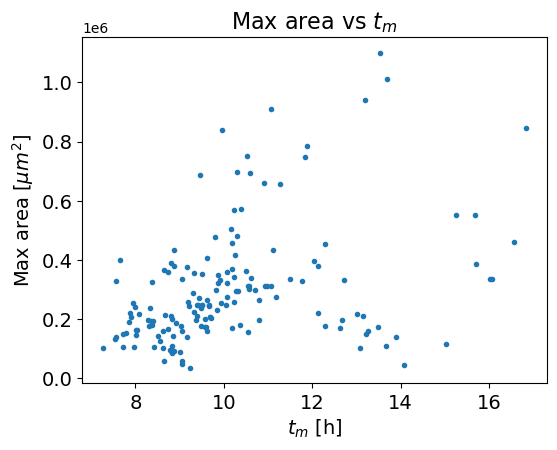

In [77]:
plt.figure(figsize=(6,4.5))

plt.plot(df['tm_um'] / 60, df['area_max_um'], '.')
plt.ylabel('Max area [$\\mu m^2$]', fontsize=14)
# plt.ylim([0,50])  # Commented out as requested
plt.xlabel('$t_m$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Max area vs $t_m$', fontsize=16)
plt.tight_layout()
#plt.savefig('MaxArea_tm.png', dpi=300)
plt.show()


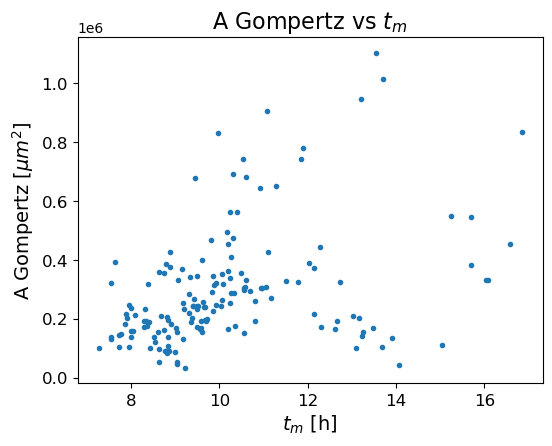

In [86]:
plt.figure(figsize=(6,4.5))

plt.plot(df['tm_um'] / 60, df['A_gomp_um'], '.')
plt.ylabel('A Gompertz [$\\mu m^2$]', fontsize=14)
# plt.xlim([0,18])  # Commented out as requested
plt.xlabel('$t_m$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title('A Gompertz vs $t_m$', fontsize=16)
plt.tight_layout()
#plt.savefig('AGomp_tm.png', dpi=300)
plt.show()


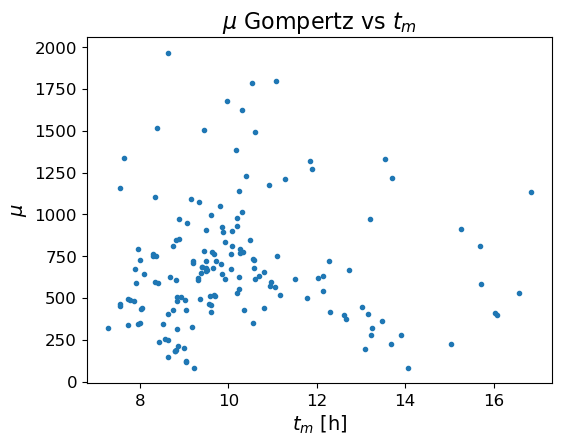

In [90]:
plt.figure(figsize=(6,4.5))

# plt.yscale('log')  # Commented out as requested
plt.plot(df['tm_um'] / 60, df['mu_gomp_um'], '.')
plt.ylabel('$\\mu$', fontsize=14)
# plt.ylim([0,20])
plt.xlabel('$t_m$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title('$\\mu$ Gompertz vs $t_m$', fontsize=16)
plt.tight_layout()
#plt.savefig('muGomp_tm.png', dpi=300)
plt.show()

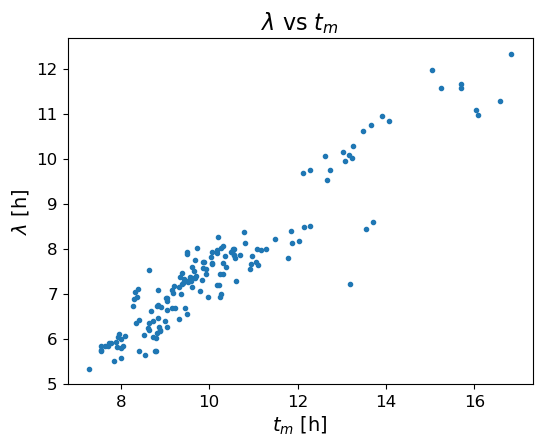

In [93]:
plt.figure(figsize=(6,4.5))

plt.plot(df['tm_um'] / 60, df['l_gomp_um'] / 60, '.')
plt.ylabel('$\\lambda$ [h]', fontsize=14)
# plt.ylim([0,20])  # Commented out as requested
plt.xlabel('$t_m$ [h]', fontsize=14)

# Adjust tick size
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title('$\\lambda$ vs $t_m$', fontsize=16)
plt.tight_layout()
#plt.savefig('lGomp_tm.png', dpi=300)
plt.show()


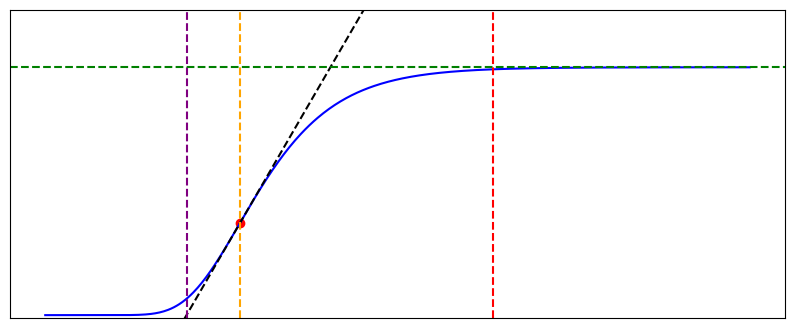

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# Gompertz function definition
def gompertz(t, A, mu, l):
    return A * np.exp(-np.exp(mu * np.exp(1) / A * (l - t) + 1))

# Derivative of the Gompertz function (numerical derivative)
def gompertz_derivative(t, A, mu, l):
    epsilon = 1e-5  # Small value for numerical differentiation
    return (gompertz(t + epsilon, A, mu, l) - gompertz(t - epsilon, A, mu, l)) / (2 * epsilon)

# Gompertz parameters (use the provided values)
# pAAA 11_30 pos 15 Tweez
gomp_params = {"A": 86590.16997388891, "mu_m": 242.29351344003047, "lambda": 350.9260575006792}
A = gomp_params['A']
mu_m = gomp_params['mu_m']
lambda_ = gomp_params['lambda']

# Time range for plotting
t = np.linspace(0, 1750, 500)

# Calculate Gompertz curve
gompertz_values = gompertz(t, A, mu_m, lambda_)

# Calculate the derivative of the Gompertz curve numerically
gompertz_derivatives = gompertz_derivative(t, A, mu_m, lambda_)

# Find the maximum derivative and its index (this corresponds to the inflection point)
max_slope_index = np.argmax(gompertz_derivatives)
max_slope = gompertz_derivatives[max_slope_index]
t_max_slope = t[max_slope_index]  # Automatically obtained, not hardcoded
y_max_slope = gompertz(t_max_slope, A, mu_m, lambda_)

# Find the intersection of the tangent line with the x-axis (i.e., y = 0)
lambda_calculated = t_max_slope - y_max_slope / max_slope

# Create the plot
plt.figure(figsize=(10,4))

# Plot the Gompertz curve
plt.plot(t, gompertz_values, label="Gompertz curve", color='blue')

# Plot the point of maximum derivative (inflection point)
plt.scatter(t_max_slope, y_max_slope, color='red', label=f'Max slope (t={t_max_slope:.2f}, y={y_max_slope:.2f})')

# Plot the tangent line at the maximum slope
tangent_line = max_slope * (t - t_max_slope) + y_max_slope
plt.plot(t, tangent_line, color='black', linestyle='--', label=f'Tangent line at max slope = {max_slope:.2f}')

# Plot vertical line at lambda_calculated (intersection with x-axis)
plt.axvline(x=lambda_calculated, color='purple', linestyle='--', label=f'Calculated Lambda = {lambda_calculated:.2f}')

# Plot horizontal line for A (asymptote)
plt.axhline(y=A, color='green', linestyle='--', label=f'Asymptote A = {A:.2f}')

# Plot vertical line where maximum slope occurs (t_max_slope)
plt.axvline(x=t_max_slope, color='orange', linestyle='--', label=f'Max slope time (t = {t_max_slope:.2f})')

# Plot vertical line at t = 1111
plt.axvline(x=1111, color='red', linestyle='--', label='Vertical line at t = 1111')

# Add labels and legend
#plt.xlabel('Time (t)', fontsize=14)
#plt.ylabel('Population/Area', fontsize=14)
#plt.title('Gompertz Model with Inflection Point and Tangent Line', fontsize=16)
#plt.legend()

# Set y-limits for a cleaner view
plt.ylim([-1000, A + 20000])

plt.xticks([])
plt.yticks([])
plt.savefig('Gomp_cartoon.png',dpi=300)
# Show the plot
plt.show()
